In [ ]:
# Introduction
- Our team's project is to create coding to do data analysis.
- Our team members are 김동구, 김민재, 박찬근.
- The role of team members is to develop code and communicate with customer. And professor's role is a mentor and client for our team.



# Objective of project
- This objective of project is to analyze the received raw data and deliver it in the form of a documentation file.


# Structure of code
![flow_chart.png](./image/flow_chart.png)
- The figure above is the overall flow chart of this program. It consists of a total of 8 modules : 7 src modules and run.py.
    
- When the program runs run.py, In process.py, several modules calculate. And plotted data are saved into integrated form. 

- From now, we will explain each module.

##  1. run.py
  - run.py is the module responsible for running the program. When you put the data to be analyzed in the data folder and run run.py, the program is operated by importing process.py.

##  2. process.py
  - process.py is the central module of the program. It parses raw data xml files in the data folder and delivers the data to the plot module and fitting module, collects the plotted figure, and saves it as a png file and saves other information as a csv file.
![process.png](./image/process.png)
```python
    plt.figure(figsize = (18,12))
    plt.subplot(234)
    IVvoltage = tree.findall(
        'ElectroOpticalMeasurements/ModulatorSite/Modulator/PortCombo/IVMeasurement/Voltage')
    IVcurrent = tree.findall(
        'ElectroOpticalMeasurements/ModulatorSite/Modulator/PortCombo/IVMeasurement/Current')
    IVplot(IVvoltage,IVcurrent)
    IVfitting(IVvoltage,IVcurrent)
```
    
    - Code that gives raw data to the module and receives the plotted figure.

## 3. data_set.py

```python
    def data_set(data,ab=0):
        value = []
        for i in range(0,len(data)):
            value1 = data[i].text.split(',')
            value1 = list(map(float,value1))
            if ab == 0:
                value.append(value1)
            elif ab == 1:
                value2 = list(map(abs,value1))
                value.append(value2)
        return value
```
  - Module that converts the values listed in str format of each raw data into a list of float that can be calculated on.
  
## 4. R_square.py
```python
def R_square(y_value,fit_value):
    y_value_mean = np.mean(np.ravel(y_value))
    Tss = np.sum((np.ravel(y_value)-y_value_mean)**2)
    Rss = np.sum((np.ravel(y_value)-np.ravel(fit_value))**2)
    results = 1 - (Rss/Tss)
    return results
```
  - Module that calculates Rsq value of the fitting function.

## 5. poly_fitting.py
```python
def polyfitting_p1d1(number,x,y):
    p_list = []
    for i in range(13,number):
        p_list.append(np.polyfit(x,y,i))
    p1d_list = []
    for i in range(13,number):
        p1d_list.append(np.poly1d(p_list[i-13]))
    return p1d_list
```
  - Module that fitting the inputed raw data with a polynomial function using numpy's polyfit. Fitting from the starting number of for loop to the order of number and store each in a list.

## 6. ILplot.py
```python
def IL_raw_plot(x,y):
    IL_x = data_set(x)
    IL_y = data_set(y)
    for i in range(0,len(x)):
        plt.scatter(IL_x[i],IL_y[i],label = DC_li[i])
    plt.ylabel('Measured transmission[dB]')
    plt.xlabel('Wavelength[nm]')
    plt.title('Transmission spectra - as measured')
    plt.legend(ncol=4)

def IL_fitting_ref(x,y,order=6):
    IL_x = data_set(x)
    IL_y = data_set(y)
    rs_list = R_square.find_R_square(order, IL_x[6], IL_y[6])
    fit_data = polyfitting_po(order, IL_x[6], IL_y[6])
    for i in range(4,order):
        plt.plot(IL_x[6],fit_data[i-4],label='{}{} {} {}'.format(i,'$^{th}$','$R^{2}$ =',round(rs_list[i-4],5)))
    plt.legend(ncol=2, loc=8)
    plt.ylabel('Measured transmission[dB]')
    plt.xlabel('Wavelength[nm]')
    plt.title('Transmission spectra - processed ref')

def IL_processed_plot(x,y,order=6):
    IL_x = data_set(x)
    IL_y = data_set(y)
    ind_IL = R_square.find_best_fit_ind(order, IL_x[6], IL_y[6])
    fit_data = polyfitting_po(order,IL_x[6],IL_y[6])
    for i in range(0, len(x)):
        x = IL_x[i]
        y = []
        try:
            for k in range(0,len(IL_y[i])):
                y.append(float(IL_y[i][k])-fit_data[ind_IL][k])
        except:
            x = IL_x[i][0:len(fit_data[ind_IL])]
            y = y[0:len(fit_data[ind_IL])]
        plt.plot(x, y, label=DC_li[i])
    plt.legend(ncol=4)
    plt.ylabel('Measured transmission[dB]')
    plt.xlabel('Wavelength[nm]')
    plt.title('Transmission spectra - as measured & processed for {}{} fit ref'.format(ind_IL+4, '$^{th}$'))
```
  - Module that draws a total of 3 graphs, including Intestiy and Wavelength raw data plot, reference fitting function plot, and plot processed with raw data by fitting function. The defined function name and role are same.

## 7. exp_fitting.py
```python
def IVfitting(x,y,number=0):
    global R
    def expfuc(x, a, b, c):
        return b * (np.exp(a * x) - 1) * c + IV_fit_value[i](x)
    IV_x = data_set(x)
    IV_y = data_set(y,1)
    IV_fit_value = polyfitting_p1d1(15,IV_x[number][:10],IV_y[number][:10])
    emodel = Model(expfuc)
    fit_result = []
    fit = []
    for i in range(0,len(IV_fit_value)):
        result1 = emodel.fit(IV_y[number],x = IV_x[number], b = 1, a = 1, c = 1)
        R = R_square(IV_y[number],result1.best_fit)
        fit_result.append(R)
        fit.append(result1.best_fit)
    rs_min = []
    for i in range(0,len(fit_result)):
        rs_min.append(abs(fit_result[i]-1))
    rs_min2 = min(rs_min)
    IV_ind = rs_min.index(rs_min2)
    R = fit_result[IV_ind]

    global IV_dic
    plt.plot(IV_x[number],fit[IV_ind],'r-',label = '{} {} {}'.format('processed',IV_ind+13,'th'))
    IV_dic = {y:x for x,y in zip(fit[IV_ind],IV_x[number])}
    plt.text(1.0,IV_dic[1.0],IV_dic[1.0],fontsize = 8,horizontalalignment = 'right')
    plt.text(-1.0,IV_dic[-1.0],IV_dic[-1.0],fontsize = 8)
    plt.xlabel('Voltage[V]')
    plt.ylabel('Current[A]')
    plt.title('IV-analysis raw & processed')
    plt.yscale("log")
    plt.legend(loc = 'best')
```
  - In the case of IV fitting, It is difficult to fitting only with the shockley equation, so that polynomial function term is added for fitting. 
  - Module in poly_fittinf.py, polynomial function fitting is first perfomed, then each is added with the exp function to fitting each and compare Rsq to find the most accurate fitting function and proceed to the plot. 
    
  
## 8. IVplot.py
```python
def IVplot(x,y,number=0):
    IV_x = data_set(x)
    IV_y = data_set(y, 1)
    plt.scatter(IV_x[number], IV_y[number], label='{}'.format('Raw IV'))
    plt.xlabel('Voltage[V]')
    plt.ylabel('Current[A]')
    plt.title('IV-analysis raw & processed')
    plt.yscale("log")
```
  - Module that plot raw data of IV

# Example of analysis result
  - sample image of analysis result
![example_figure.png](./image/example_figure.png)

  - a table in csv file


In [2]:
!pip install pandas
import pandas as pd

df = pd.read_csv(r'../result/csv/analy_result.csv')
print(df)

    Unnamed: 0      Lot Wafer      Mask  TestSite                  Name  \
0          NaN  P184640   D07  GORILLA5  DCM_LMZC  MZMCTE_LULAB_450_500   
1          NaN  P184640   D07  GORILLA5  DCM_LMZC  MZMCTE_LULAB_450_500   
2          NaN  P184640   D07  GORILLA5  DCM_LMZC  MZMCTE_LULAB_450_500   
3          NaN  P184640   D07  GORILLA5  DCM_LMZC  MZMCTE_LULAB_450_500   
4          NaN  P184640   D07  GORILLA5  DCM_LMZC  MZMCTE_LULAB_450_500   
..         ...      ...   ...       ...       ...                   ...   
93         NaN  P184640   D24  GORILLA5  DCM_LMZO  MZMOTE_LULAB_380_500   
94         NaN  P184640   D24  GORILLA5  DCM_LMZO  MZMOTE_LULAB_380_500   
95         NaN  P184640   D24  GORILLA5  DCM_LMZO  MZMOTE_LULAB_380_500   
96         NaN  P184640   D24  GORILLA5  DCM_LMZO  MZMOTE_LULAB_380_500   
97         NaN  P184640   D24  GORILLA5  DCM_LMZO  MZMOTE_LULAB_380_500   

               Date  Operator  Row  Column  error_flag_TMW  \
0   20190715_191703      ykim   -1   

# Result of wafer-to-wafer using csv file

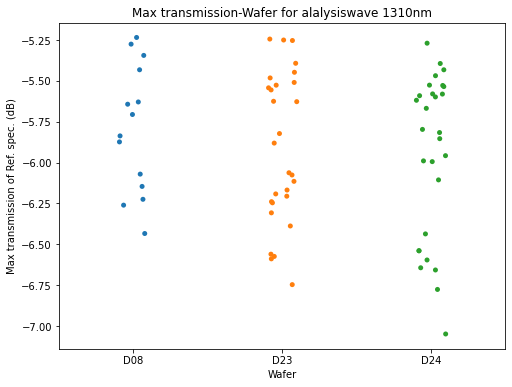

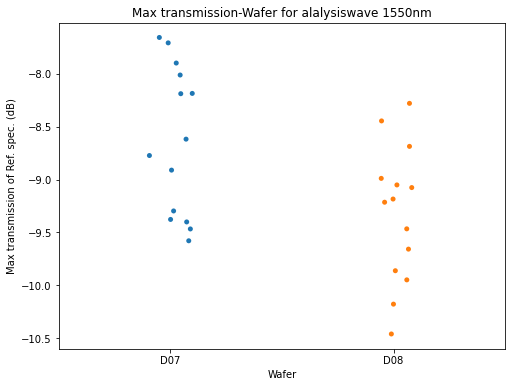

In [3]:
!pip install seaborn
!pip install matplotlib
!pip install pandas
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv(r'../result/csv/analy_result.csv')
wafer_num = list(df['Wafer'])
maxtrans = list(df['Max transmission of Ref. spec. (dB)'])
analywave = list(df['Analysis Wavelength'])
wafer_1550 = []
wafer_1310 = []
maxtrans_1550 = []
maxtrans_1310 = []
for i in range(0,len(analywave)):
    if analywave[i] == 1310:
        wafer_1310.append(wafer_num[i])
        maxtrans_1310.append(maxtrans[i])
    elif analywave[i] == 1550:
        wafer_1550.append(wafer_num[i])
        maxtrans_1550.append(maxtrans[i])

plt.figure(figsize = (8,6))

plot1310 = sns.stripplot(x=wafer_1310,y=maxtrans_1310)
plot1310.set_title("Max transmission-Wafer for alalysiswave 1310nm")
plt.xlabel("Wafer")
plt.ylabel("Max transmission of Ref. spec. (dB)")
plt.show()

plt.figure(figsize = (8,6))
plot1550 = sns.stripplot(x=wafer_1550,y=maxtrans_1550)
plot1550.set_title("Max transmission-Wafer for alalysiswave 1550nm")
plt.xlabel("Wafer")
plt.ylabel("Max transmission of Ref. spec. (dB)")
plt.show()

## Error File list

In [4]:
!pip install pandas
import pandas as pd
df = pd.read_csv(r'../result/csv/analy_result.csv')
wafer_num = list(df['Wafer'])
error_list = list(df['error_description_IV'])
lot_list = list(df['Lot'])
row_list = list(df['Row'])
column_list = list(df['Column'])
mask_list = list(df['Mask'])
testsite_list = list(df['TestSite'])
error_file_list = []
for i in range(0,len(error_list)):
    if error_list[i] == 'Rsq error':
        error_file_list.append('{}_{}_({},{})_{}_{}{}'.format(lot_list[i],
                                                             wafer_num[i],
                                                             row_list[i],
                                                             column_list[i],
                                                             mask_list[i],
                                                              testsite_list[i],
                                                             '.xml'))
print('')
for i in range(0,len(error_file_list)):
    print(error_file_list[i])


P184640_D23_(-1,-1)_GORILLA5_DCM_LMZO.xml
P184640_D23_(-1,-3)_GORILLA5_DCM_LMZO.xml
P184640_D23_(-1,3)_GORILLA5_DCM_LMZO.xml
P184640_D23_(-3,-3)_GORILLA5_DCM_LMZO.xml
P184640_D23_(-3,0)_GORILLA5_DCM_LMZO.xml
P184640_D23_(-3,2)_GORILLA5_DCM_LMZO.xml
P184640_D23_(-4,-1)_GORILLA5_DCM_LMZO.xml
P184640_D23_(0,-4)_GORILLA5_DCM_LMZO.xml
P184640_D23_(0,0)_GORILLA5_DCM_LMZO.xml
P184640_D23_(0,2)_GORILLA5_DCM_LMZO.xml
P184640_D23_(2,-1)_GORILLA5_DCM_LMZO.xml
P184640_D23_(2,-3)_GORILLA5_DCM_LMZO.xml
P184640_D23_(2,2)_GORILLA5_DCM_LMZO.xml
P184640_D23_(3,0)_GORILLA5_DCM_LMZO.xml
P184640_D24_(-1,-1)_GORILLA5_DCM_LMZO.xml
P184640_D24_(-1,-3)_GORILLA5_DCM_LMZO.xml
P184640_D24_(-1,3)_GORILLA5_DCM_LMZO.xml
P184640_D24_(-3,-3)_GORILLA5_DCM_LMZO.xml
P184640_D24_(-3,0)_GORILLA5_DCM_LMZO.xml
P184640_D24_(-3,2)_GORILLA5_DCM_LMZO.xml
P184640_D24_(-4,-1)_GORILLA5_DCM_LMZO.xml
P184640_D24_(0,0)_GORILLA5_DCM_LMZO.xml
P184640_D24_(0,2)_GORILLA5_DCM_LMZO.xml
P184640_D24_(2,-1)_GORILLA5_DCM_LMZO.xml
P184640_D24_(

## There are some error with the data, check please.